In [51]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Implementing classes and real network

In [52]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    """
    data : (10 000 x 3072)
    labels : (10 000 x 1)
    one_hot : (10 000 x 10)
    """
    
    file = unpickle("data/cifar-10-batches-py/data_batch_1")
    labels = file[b'labels']
    data = file[b'data']
    no_classes = 10
    N = len(labels)
    
    one_hot = np.zeros((N, no_classes))
    one_hot[np.arange(N), labels] = 1
    
    labels = np.array(labels).reshape(-1,1)
    
    # normalize
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    
    X = (data - mean) / std
    return X, labels, one_hot, mean, std

def ReLU(x):
    return np.where(x > 0, x, 0)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def plot_image(x, mean, std):
    x = (x.T * std + mean).astype(int)
    img = x.reshape(3,32,32)
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(img, (1,2,0)))

def check_if_correct(y, p):
    temp = np.argmax(y, axis=1) - np.argmax(p.T, axis=1)
    correct_ones = np.where(temp == 0, 1, 0)
    return np.sum(correct_ones)

def print_info(plotter, epoch, avg_loss, accuracy):
    if (epoch % 10 == 0):
        plotter.add(epoch, avg_loss)
        print("epoch: {} \tloss: {:.3} \tacc: {:.3}".format(epoch, avg_loss, accuracy))

class Plotter:
    def __init__(self, title):
        self.title = title
        self.x = []
        self.y = []
        
    def add(self, epoch, cost):
        self.y.append(cost)
        self.x.append(epoch)
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y)

        ax.set(xlabel="epochs", ylabel="cost", title=self.title)
        ax.grid()
        # fig.savefig("{}.png".format(self.title))
        plt.show()


In [57]:
batch_size = 100
w_decay = 0
lr = 0.05
batch_norm = False

class Layer:
    def __init__(self, in_size, out_size):
        self.W = np.random.rand(out_size, in_size) * 0.0001
        self.b = np.zeros((out_size, 1))
        
        if batch_norm:
            self.gamma = np.random.rand(out_size, 1)
            self.beta = np.zeros((out_size, 1))
    
    def forward(self, input):
        if batch_norm:
            self.input = input
            self.S = np.dot(self.W, input) + self.b
            self.mu = np.sum(self.S, axis=1).reshape(-1,1) / batch_size
            self.var = np.var(self.S, axis=1)

            self.S_hat = np.dot(np.diag( (self.var + 1e-15) ** (-0.5) ), (self.S - self.mu))
            self.S_t = self.gamma * self.S_hat + self.beta

            self.output = ReLU(self.S_t)
            return self.output
        else:
            self.input = input
            self.S = np.dot(self.W, input) + self.b
            self.output = ReLU(self.S)
            return self.output
    
    def backprop(self, G):
        G = G * dReLU(self.output)
        
        if batch_norm:
            self.dgamma = np.sum(G * self.S_hat, axis=1, keepdims=True) / batch_size
            self.dbeta = np.sum(G, axis=1, keepdims=True) / batch_size

            G = G * self.gamma

            sigma = self.var.reshape(-1,1) + 1e-15
            G1 = G * (sigma ** -0.5)
            G2 = G * (sigma ** -1.5)

            D = self.S - self.mu
            c = np.sum(G2 * D, axis=1, keepdims=True)
            part1 = (1 / batch_size) * (G1 @ np.ones((batch_size, 1))) @ np.ones((1, batch_size))
            part2 = (1 / batch_size) * D * (c @ np.ones((1, batch_size)))

            G = G1 - part1 - part2

            self.dW = (np.dot(G, self.input.T) / batch_size) + w_decay * 2 * self.W
            self.db = np.sum(G, axis=1).reshape(-1,1) / batch_size

            return np.dot(self.W.T, G)
        else:
            self.dW = (np.dot(G, self.input.T) / batch_size) + w_decay * 2 * self.W
            self.db = np.sum(G, axis=1).reshape(-1,1) / batch_size
            
            return np.dot(self.W.T, G)
    
    def update(self):
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.b
        
        if batch_norm:
            self.gamma = self.gamma - lr * self.dgamma
            self.beta = self.beta - lr * self.dbeta
        
class LastLayer:
    def __init__(self, in_size, no_classes):
        self.W = np.random.rand(no_classes, in_size) * 0.0001
        self.b = np.zeros((no_classes, 1))
        
    def forward(self, input):
        self.input = input
        S = np.dot(self.W, input) + self.b
        self.output = softmax(S)
        return self.output
    
    def backprop(self, G):
        self.dW = (np.dot(G, self.input.T) / batch_size) + 2 * w_decay * self.W
        self.db = np.sum(G, axis=1).reshape(-1,1) / batch_size
        
        return np.dot(self.W.T, G)

    def update(self):
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.b

def build_network(sizes):
    layers = []
    for idx in range(len(sizes) - 2):
        layers.append(Layer(sizes[idx], sizes[idx+1]))

    layers.append(LastLayer(sizes[-2], sizes[-1]))    
    return layers

epoch: 0 	loss: 2.3 	acc: 9.74
epoch: 10 	loss: 2.3 	acc: 10.1
epoch: 20 	loss: 2.18 	acc: 10.5
epoch: 30 	loss: 2.14 	acc: 10.4
epoch: 40 	loss: 2.01 	acc: 19.6
epoch: 50 	loss: 1.58 	acc: 42.2
epoch: 60 	loss: 1.29 	acc: 53.5
epoch: 70 	loss: 1.05 	acc: 62.6
epoch: 80 	loss: 0.866 	acc: 70.0
epoch: 90 	loss: 0.725 	acc: 75.9
epoch: 100 	loss: 0.604 	acc: 80.0
epoch: 110 	loss: 0.6 	acc: 82.2
epoch: 120 	loss: 0.387 	acc: 87.6
epoch: 130 	loss: 0.417 	acc: 90.0
epoch: 140 	loss: 0.205 	acc: 93.9
epoch: 150 	loss: 0.47 	acc: 91.1
epoch: 160 	loss: 0.0475 	acc: 99.2
epoch: 170 	loss: 0.0225 	acc: 99.8
epoch: 180 	loss: 0.0133 	acc: 99.9
epoch: 190 	loss: 0.00878 	acc: 1e+02
58.2 s


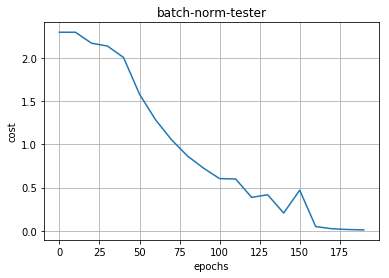

In [58]:
def train():
    plotter = Plotter("batch-norm-tester".format(time.time()))
    data, _, one_hots, mean, std = load_data()
    data_size = data.shape[0]
    
    layers = build_network([3072, 50, 50, 10])
    
    iterations = data_size // batch_size
    start_t = time.time()
    
    for epoch in range(200):
        avg_loss = 0
        accuracy = 0
        
        for idx in range(iterations):
            start = batch_size * idx
            end = batch_size * (idx + 1)
            
            # get X and Y
            X = data[start:end,:].T # 3072x100
            one_hot = one_hots[start:end,:] # 100x10
            
            for layer in layers:
                X = layer.forward(X)
            
            output = X

            # Loss
            L2 = 0
            for layer in layers:
                L2 += np.sum(layer.W ** 2)
            
            loss = -np.sum(one_hot * np.log(1e-15 + output.T)) + w_decay * L2
            
            avg_loss += (loss / batch_size)
            accuracy += check_if_correct(one_hot, output)
            
            # Backward
            G = output - one_hot.T
            
            for layer in reversed(layers):
                G = layer.backprop(G)
            
            # Update
            for layer in reversed(layers):
                layer.update()
            
        avg_loss /= iterations
        accuracy /= iterations
        
        print_info(plotter, epoch, avg_loss, accuracy)

    print("{:.3} s".format(time.time() - start_t))
    plotter.plot()
        
train()
